In [1]:
from __future__ import division

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from radar import radar_graph
#import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('AllData.csv')

#files = ['turnstile_170909.txt','turnstile_170902.txt','turnstile_170826.txt','turnstile_170819.txt']
#for f in files:
#    df = pd.concat([df, pd.read_csv(f)])


In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
df.columns = ['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXIT']
df.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXIT
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/09/2017,00:00:00,REGULAR,6318862,2138544
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/09/2017,04:00:00,REGULAR,6318888,2138549
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/09/2017,08:00:00,REGULAR,6318905,2138584
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/09/2017,12:00:00,REGULAR,6318985,2138669
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/09/2017,16:00:00,REGULAR,6319212,2138731


In [5]:
len(df['STATION'].unique())

379

I concatenate the DATE and TIME column strings into a DATE_TIME string and use pd.to_datetime to convert it to the type datetime64.

In [6]:
df["DATE_TIME"] = df["DATE"] +" "+ df["TIME"]
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"], format='%m/%d/%Y %H:%M:%S')

#df = df[df.DATE_TIME.apply(lambda x: x.dt.weekday in range(5))]

I create a column of ones which I can resample to count traffic during each hour.

In [7]:
df[['DIFF_ENTRY' , 'DIFF_EXIT', 'DIFF_DATE_TIME']] = (df.groupby(["CA", "UNIT", "SCP", "STATION"])["ENTRIES", "EXIT", "DATE_TIME"]
                                                       .transform(lambda grp: grp.diff()))
df['TRAFFIC'] = df['DIFF_ENTRY'] + df['DIFF_EXIT'] 
#df_hour_count = df_hour_count.dropna()
df = df[(df.TRAFFIC < 100000) & 
        (df.TRAFFIC >0) &
        (df.DIFF_DATE_TIME.astype('timedelta64[h]') > 0)]
df['TRAFFIC_HOURLY'] = df['TRAFFIC'] / df['DIFF_DATE_TIME'].astype('timedelta64[h]')
#df[df.DIFF_DATE_TIME.astype('timedelta64[h]') > 4]

In [8]:
df.groupby('STATION')['TRAFFIC'].sum().sort_values(ascending = False)[:11]

STATION
34 ST-PENN STA     42538700.0
GRD CNTRL-42 ST    38588999.0
34 ST-HERALD SQ    31835277.0
14 ST-UNION SQ     28684787.0
TIMES SQ-42 ST     28076557.0
23 ST              27639624.0
FULTON ST          23887673.0
42 ST-PORT AUTH    23701953.0
86 ST              22280768.0
125 ST             19127154.0
CANAL ST           18890931.0
Name: TRAFFIC, dtype: float64

In [9]:
df['WEEK_DAY'] = df.DATE_TIME.dt.weekday

In [10]:
df_daily_station_mean = (df.groupby(['STATION', 'WEEK_DAY'])['TRAFFIC_HOURLY']
                         .mean()
                         .reset_index())

In [11]:
def plot_stations_daily(stations):
    grid = range(0, 7)
    y = {}
    for station in stations:
        y[station] = []
        for x in grid:
            y[station].append(int(df_daily_station_mean
                                  .TRAFFIC_HOURLY[(df_daily_station_mean.WEEK_DAY == x)&
                                                  (df_daily_station_mean.STATION == station)]
                                  .values))
    #print y
    # radar_graph plots each data series in dict y on one radar graph.
    radar_graph(labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], values=y)

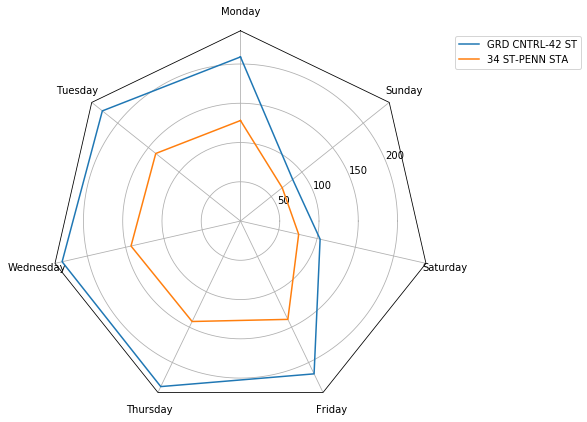

In [12]:
plot_stations_daily(['34 ST-PENN STA', 'GRD CNTRL-42 ST'])

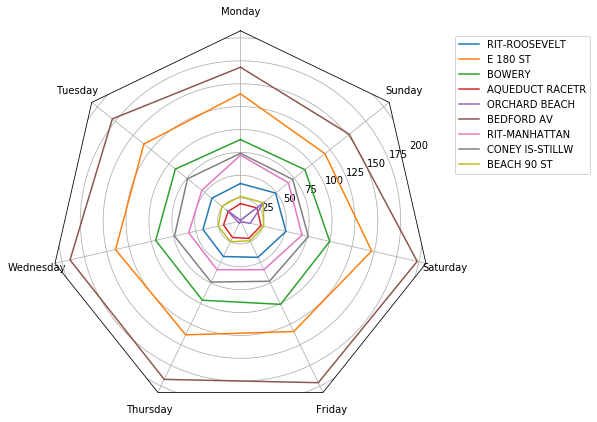

In [13]:
#plot_stations_daily(['TIMES SQ-42 ST', 'GRD CNTRL-42 ST'])
out = []
for name, group in df_daily_station_mean.groupby(["STATION"]):
    Sat = group.TRAFFIC_HOURLY.values[5]
    Mon = group.TRAFFIC_HOURLY.values[2]
    if Sat > Mon:
        out.append(group.STATION.values[0])
plot_stations_daily(out)

In [14]:
df = df[df.DATE_TIME.dt.weekday < 5]

In [15]:
df_time_station_count = (df.groupby(['STATION', 'TIME'])['TRAFFIC_HOURLY']
                         .mean()
                         .reset_index())
df_time_station_count = df_time_station_count[df_time_station_count['TIME']
                                              .apply(lambda x: x[2:] == ":00:00")]
df_time_station_count['TIME'] = df_time_station_count['TIME'].apply(lambda x: int(x[:2]))

In [16]:
df_time_station_count[df_time_station_count.STATION == '34 ST-PENN STA']

,STATION,TIME,TRAFFIC_HOURLY
6326,34 ST-PENN STA,0,66.806458
6327,34 ST-PENN STA,2,57.192661
6329,34 ST-PENN STA,4,8.589363
6333,34 ST-PENN STA,6,18.277901
6374,34 ST-PENN STA,8,78.399759
6414,34 ST-PENN STA,10,368.340981
6433,34 ST-PENN STA,12,186.756720
6448,34 ST-PENN STA,14,184.496325
6457,34 ST-PENN STA,16,133.687431
6460,34 ST-PENN STA,18,312.528764


In [17]:
def spline(t, t1, t2, n1, n2):    
    return n1+(n2-n1)/(t2-t1)*(t-t1)

def get_n(t1,t2,df,station):
    #print t1, t2
    n1 = int(df.TRAFFIC_HOURLY[(df.TIME == t1) &(df.STATION == station)].values)
    n2 = int(df.TRAFFIC_HOURLY[(df.TIME == t2) &(df.STATION == station)].values)
    return n1, n2

def find_first(t_min, times):
    if t_min < times.min():
        t1 = times[times <= t+25].max() - 24
    else:
        t1 = times[times <= t].max()
    return t1

def find_next(t, times):
    if t > t_max:
        t2 = times[times > t-25].min() + 24
    else:
        t2 = times[times > t]

def interpolation(ts, station, df):
    times = df.TIME[df.STATION == station]
    t1 = find_first(t[0], times)
    t2 = find_next(t)
    for t in ts:
        
    if t < times.min():
        t1 = times[times <= t+25].max()
        t2 = times[times > t].min()
        n1, n2 = get_n(t1,t2,df,station)
        t1 = t1-24
    elif t >= times.max():
        t1 = times[times <= t].max()
        t2 = times[times > t-25].min()
        n1, n2 = get_n(t1,t2,df,station)
        t2 = t2+24
    else:
        t1 = times[times <= t].max()
        t2 = times[times > t].min()
        n1, n2 = get_n(t1,t2,df,station)
    return spline(t, t1, t2, n1, n2)

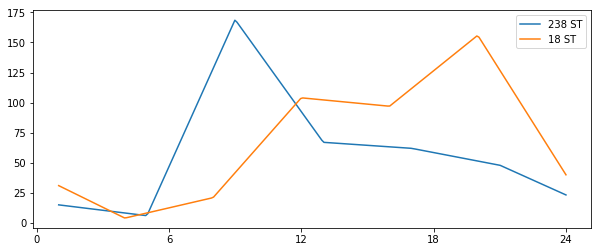

In [18]:
plt.figure(figsize=(10,4))
x = np.linspace(1, 24, 240)
stations = ['238 ST','18 ST']
for station in stations:
    y = []
    for x1 in x:
        y.append(interpolation(x1, station, df_time_station_count))
        x1 = x1 + 2 % 24
    plt.plot(x,y, label=station)
plt.legend()
plt.xticks([x for x in range(25) if x%6 == 0]);

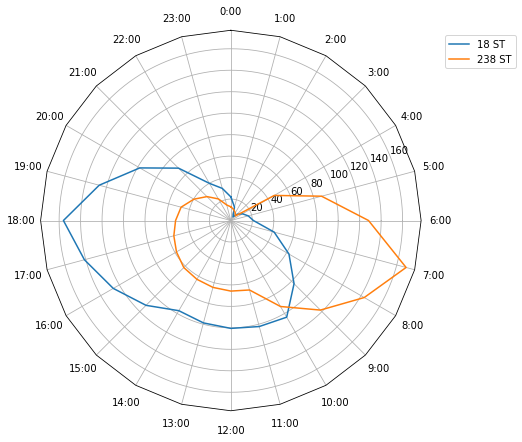

In [19]:
grid = range(23, 0, -1)
grid = [0] + grid
stations = ['238 ST','18 ST']
y = {}
for station in stations:
    y[station] = []
    for x in grid:
        x = (x + 2) % 24
        y[station].append(interpolation(x, station, df_time_station_count))
        
# radar_graph plots each data series in dict y on one radar graph.
radar_graph(labels = [str(x) + ":00" for x in grid], values=y)

In [20]:
def plot_stations(stations):
    grid = range(23, 0, -1)
    grid = [0] + grid
    y = {}
    for station in stations:
        y[station] = []
        for x in grid:
            x = (x + 2) % 24
            y[station].append(interpolation(x, station, df_time_station_count))
            
    # radar_graph plots each data series in dict y on one radar graph.
    radar_graph(labels = [str(x) + ":00" for x in grid], values=y)

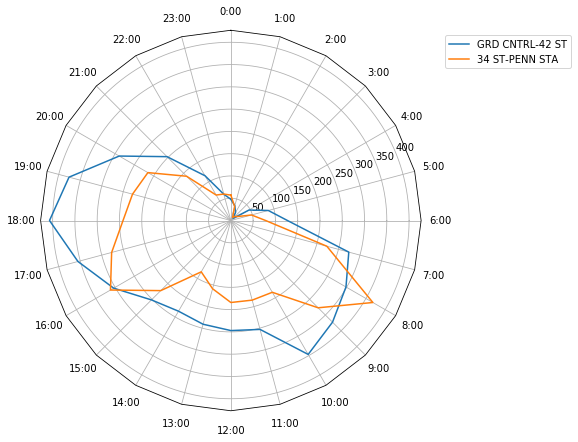

In [21]:
plot_stations(['34 ST-PENN STA', 'GRD CNTRL-42 ST'])

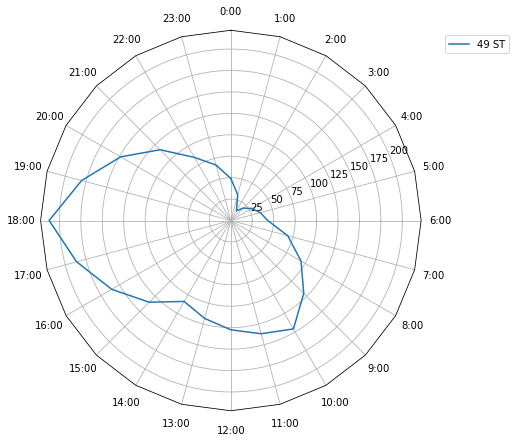

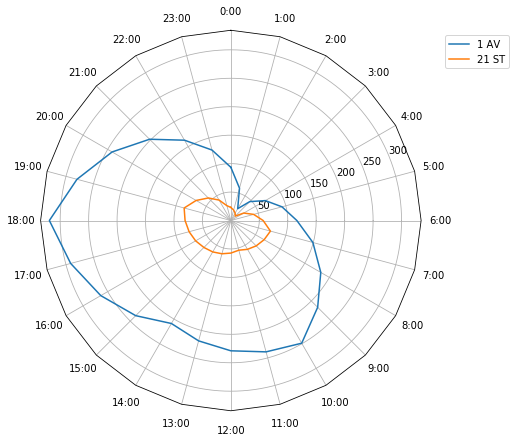

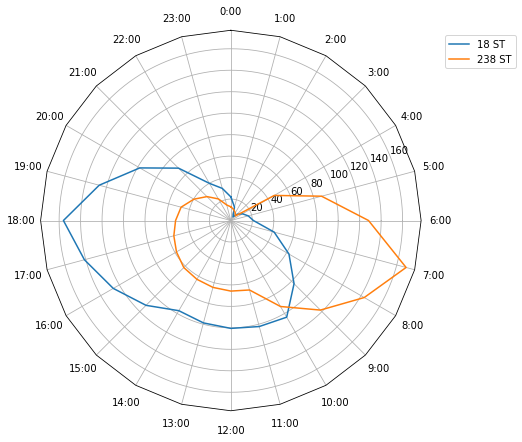

In [22]:
plot_stations(["49 ST"])
plot_stations(['1 AV', '21 ST'])
plot_stations(['238 ST','18 ST'])

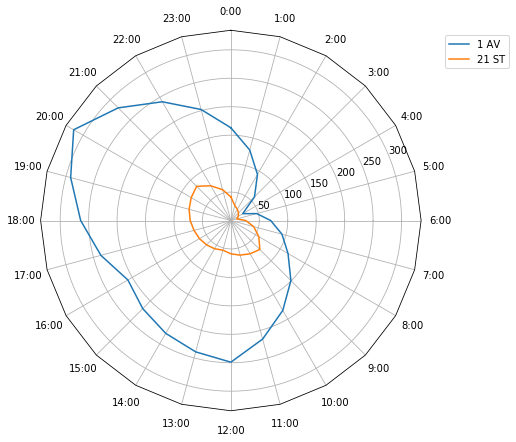

In [23]:
grid = range(23, 0, -1)
grid = [0] + grid
stations = ['1 AV','21 ST']
y = {}
for station in stations:
    y[station] = []
    for x in grid:
        y[station].append(interpolation(x, station, df_time_station_count))
        x = (x + 2) % 24
# radar_graph plots each data series in dict y on one radar graph.
radar_graph(labels = [str(x) + ":00" for x in grid], values=y)

In [38]:
tuples = [('57th St', '57 ST'),
 ('49th St', '49 ST'),
 ('28th St', '28 ST'),
 ('23rd St', '23 ST'),
 ('25th St', '25 ST'),
 ('36th St', '36 ST'),
 ('45th St', '45 ST'),
 ('53rd St', '53 ST'),
 ('59th St', '59 ST'),
 ('77th St', '77 ST'),
 ('86th St', '86 ST'),
 ('7th Av', '7 AV'),
 ('9th Av', '9 AV'),
 ('50th St', '50 ST'),
 ('55th St', '55 ST'),
 ('71st St', '71 ST'),
 ('79th St', '79 ST'),
 ('18th Av', '18 AV'),
 ('20th Av', '20 AV'),
 ('25th Av', '25 AV'),
 ('Bay 50th St', 'BAY 50 ST'),
 ('8th Av', '8 AV'),
 ('121st St', '121 ST'),
 ('111th St', '111 ST'),
 ('3rd Av', '3 AV'),
 ('1st Av', '1 AV'),
 ('East 105th St', 'EAST 105 ST'),
 ('190th St', '190 ST'),
 ('181st St', '181 ST'),
 ('175th St', '175 ST'),
 ('155th St', '155 ST'),
 ('145th St', '145 ST'),
 ('135th St', '135 ST'),
 ('125th St', '125 ST'),
 ('116th St', '116 ST'),
 ('103rd St', '103 ST'),
 ('96th St', '96 ST'),
 ('72nd St', '72 ST'),
 ('42nd St', '72 ST'),
 ('14th St', '14 ST'),
 ('174-175th Sts', '174-175 STS'),
 ('170th St', '170 ST'),
 ('167th St', '167 ST'),
 ('21st St', '21 ST'),
 ('2nd Av', '2 AV'),
 ('169th St', '169 ST'),
 ('75th Av', '75 AV'),
 ('67th Av', '67 AV'),
 ('65th St', '65 ST'),
 ('46th St', '46 ST'),
 ('5th Av-53rd St', '5 AV/53 ST'),
 ('238th St', '238 ST'),
 ('231st St', '231 ST'),
 ('215th St', '215 ST'),
 ('191st St', '191 ST'),
 ('157th St', '157 ST'),
 ('18th St', '18 ST'),
 ('East 149th St', 'E 149 ST'),
 ('183rd St', '183 ST'),
 ('176th St', '176 ST'),
 ('110th St', '110 ST'),
 ('51st St', '51 ST'),
 ('33rd St', '33 ST'),
 ('233rd St', '233 ST'),
 ('225th St', '225 ST'),
 ('219th St', '219 ST'),
 ('East 180th St', 'E 180 ST'),
 ('174th St', '174 ST'),
 ('6th Av', '6 AV'),
 ('168th St', '168 ST'),
 ('163rd St - Amsterdam Av', '163 ST-AMSTERDM'),
 ('Zerega Av', 'ZEREGA AV'),
 ('138th St-3 AVe', '3 AV 138 ST'),
 ('138th St', '138/GRAND CONC'),
 ('137th St-City College', '137 ST CITY COL'),
 ('York St', 'YORK ST'),
 ('116 ST-Columbia University', '116 ST-COLUMBIA'),
 ('World Trade Center', 'WORLD TRADE CTR'),
 ('14 ST-Union Square', '14 ST-UNION SQ'),
 ('Woodlawn', 'WOODLAWN'),
 ('149 ST-Grand Concourse', '149/GRAND CONC'),
 ('207th St', '207 ST'),
 ('Woodhaven Blvd', 'WOODHAVEN BLVD'),
 ('Winthrop St', 'WINTHROP ST'),
 ('Wilson Av', 'WILSON AV'),
 ('Rawson St-33 ST', '33 ST-RAWSON ST'),
 ('66th St-Lincoln Center', '66 ST-LINCOLN'),
 ('Whitlock Av', 'WHITLOCK AV'),
 ('Elderts Lane-75th St', '75 ST-ELDERTS'),
 ('Wall St', 'WALL ST'),
 ('182nd-183 STs', '182-183 STS'),
 ('Brooklyn Bridge-City Hall', 'BROOKLYN BRIDGE'),
 ('Wakefield-241st St', 'WAKEFIELD/241'),
 ('Vernon Blvd-Jackson Av', 'VERNON-JACKSON'),
 ('Carroll St', 'CARROLL ST'),
 ('West 4th St', 'W 4 ST-WASH SQ'),
 ('39 Av-Beebe Av', '39 AV'),
 ('Alabama Av', 'ALABAMA AV'),
 ('Union St', 'UNION ST'),
 ('59 ST-Columbus Circle', '59 ST COLUMBUS'),
 ('68th St-Hunter College', '68ST-HUNTER CO'),
 ('Allerton Av', 'ALLERTON AV'),
 ('Van Siclen Av', 'VAN SICLEN AV'),
 ('Woodside Av-61st St', '61 ST WOODSIDE'),
 ('Utica Av', 'UTICA AV'),
 ('82nd St-Jackson Heights', '82 ST-JACKSON H'),
 ('Lowery St-40th St', '40 ST LOWERY ST'),
 ('63rd Drive-Rego Park', '63 DR-REGO PARK'),
 ('Aqueduct Racetrack', 'AQUEDUCT RACETR'),
 ('West 8th St', 'W 8 ST-AQUARIUM'),
 ('Jackson Av', 'JACKSON AV'),
 ('Bay Parkway', 'BAY PKWY'),
 ('Whitehall St', 'WHITEHALL S-FRY'),
 ('Church Av', 'CHURCH AV'),
 ('Westchester Square-East Tremont Av', 'WESTCHESTER SQ'),
 ('Av I', 'AVENUE I'),
 ('Av J', 'AVENUE J'),
 ('Av M', 'AVENUE M'),
 ('Av N', 'AVENUE N'),
 ('Av P', 'AVENUE P'),
 ('Av U', 'AVENUE U'),
 ('Av X', 'AVENUE X'),
 ('Atlantic Av-Barclays Ctr', 'ATL AV-BARCLAY'),
 ('Av H', 'AVENUE H'),
 ('Bay Ridge Av', 'BAY RIDGE AV'),
 ('Tremont Av', 'TREMONT AV'),
 ('Broadway', 'BROADWAY'),
 ('Brook Ave', 'BROOK AV'),
 ('Buhre Av', 'BUHRE AV'),
 ('Elder Av', 'ELDER AV'),
 ('Burke Av', 'BURKE AV'),
 ('Beach 105th St', 'BEACH 105 ST'),
 ('Beach 25 ST', 'BEACH 25 ST'),
 ('Beach 36 ST', 'BEACH 36 ST'),
 ('Beach 44th St', 'BEACH 44 ST'),
 ('Beach 60th St', 'BEACH 60 ST'),
 ('Beach 67th St', 'BEACH 67 ST'),
 ('Beach 90th St', 'BEACH 90 ST'),
 ('Beach 98th St', 'BEACH 98 ST'),
 ('Burnside Av', 'BURNSIDE AV'),
 ('Bushwick Av', 'BUSHWICK AV'),
 ('Canal St', 'CANAL ST'),
 ('Euclid Av', 'EUCLID AV'),
 ('Castle Hill Av', 'CASTLE HILL AV'),
 ('Central Av', 'CENTRAL AV'),
 ('Christopher St', 'CHRISTOPHER ST'),
 ('Elmhurst Av', 'ELMHURST AV'),
 ('Bowery', 'BOWERY'),
 ('Broadway Junction-East New York', 'BROADWAY JCT'),
 ('Gates Av', 'GATES AV'),
 ('Jefferson St', 'JEFFERSON ST'),
 ('Bronx Park East', 'BRONX PARK EAST'),
 ('Cleveland St', 'CLEVELAND ST'),
 ('Times Square', 'TIMES SQ-42 ST'),
 ('Clinton & Washington Avs', 'CLINTON-WASH AV'),
 ('Jamaica-179 ST', 'JAMAICA 179 ST'),
 ('Jamaica-Van Wyck', 'JAMAICA VAN WK'),
 ('Classon Av', 'CLASSON AV'),
 ('Crescent St', 'CRESCENT ST'),
 ('Van Cortlandt Park-272 ST', 'V.CORTLANDT PK'),
 ('City Hall', 'CITY HALL'),
 ('Fordham Rd', 'FORDHAM RD'),
 ('Forest Av', 'FOREST AVE'),
 ('Forest Hills-71 AV', 'FOREST HILLS 71'),
 ('Cypress Av', 'CYPRESS AV'),
 ('Cypress Hills', 'CYPRESS HILLS'),
 ('Myrtle Av', 'MYRTLE AV'),
 ('Myrtle-Willoughby Avs', 'MYRTLE-WILLOUGH'),
 ('Nassau Av', 'NASSAU AV'),
 ('Sutter Av', 'SUTTER AV'),
 ('Sutphin Blvd-Archer Av - JFK', 'SUTPHIN-ARCHER'),
 ('Far Rockaway-Mott Av', 'FAR ROCKAWAY'),
 ('Franklin Av', 'FRANKLIN AV'),
 ('Franklin St', 'FRANKLIN ST'),
 ('Freeman St', 'FREEMAN ST'),
 ('Fresh Pond Rd', 'FRESH POND RD'),
 ('Flushing-Main St', 'FLUSHING-MAIN'),
 ('Flushing Av', 'FLUSHING AV'),
 ('Sutphin Blvd', 'SUTPHIN BLVD'),
 ('Flatbush Av-Brooklyn College', 'FLATBUSH AV-B.C'),
 ('Neck Rd', 'NECK RD'),
 ('Neptune Av-Van Siclen', 'NEPTUNE AV'),
 ('Nevins St', 'NEVINS ST'),
 ('New Lots Av', 'NEW LOTS AV'),
 ('New Utrecht Av', 'NEW UTRECHT AV'),
 ('Newkirk Av', 'NEWKIRK AV'),
 ('Sterling St', 'STERLING ST'),
 ('Steinway St', 'STEINWAY ST'),
 ('Kings Highway', 'KINGS HWY'),
 ('Kingsbridge Rd', 'KINGSBRIDGE RD'),
 ('Kingston Av', 'KINGSTON AV'),
 ('Kingston-Throop', 'KINGSTON-THROOP'),
 ('Knickerbocker Av', 'KNICKERBOCKER'),
 ('Kosciusko St', 'KOSCIUSZKO ST'),
 ('Park Place', 'PARK PLACE'),
 ('Parkchester-East 177 ST', 'PARKCHESTER'),
 ('Parkside Av', 'PARKSIDE AV'),
 ('St Lawrence Av', 'ST LAWRENCE AV'),
 ('Spring St', 'SPRING ST'),
 ('Marble Hill-225 ST', 'MARBLE HILL-225'),
 ('Marcy Av', 'MARCY AV'),
 ('Metropolitan Av', 'METROPOLITAN AV'),
 ('Mets - Willets Point', 'METS-WILLETS PT'),
 ('Middletown Rd', 'MIDDLETOWN RD'),
 ('Montrose Av', 'MONTROSE AV'),
 ('Morgan Av', 'MORGAN AV'),
 ('Houston St', 'HOUSTON ST'),
 ('South Ferry', 'SOUTH FERRY'),
 ('Intervale Av', 'INTERVALE AV'),
 ('Briarwood-Van Wyck Blvd', 'BRIARWOOD'),
 ('Bedford Park Blvd', 'BEDFORD PK BLVD'),
 ('Bedford Av', 'BEDFORD AV'),
 ('Bergen St', 'BERGEN ST'),
 ('Bedford-Nostrand Avs', 'BEDFORD-NOSTRAN'),
 ('Beverly Rd', 'BEVERLY RD'),
 ('Bleecker St', 'BLEECKER ST'),
 ('Borough Hall', 'BOROUGH HALL'),
 ('Botanic Gardens', 'BOTANIC GARDEN'),
 ('Bowling Green', 'BOWLING GREEN'),
 ('Brighton Beach', 'BRIGHTON BEACH'),
 ('Broad Channel', 'BROAD CHANNEL'),
 ('Canarsie - Rockaway Parkway', 'CANARSIE-ROCKAW'),
 ('Chambers St', 'CHAMBERS ST'),
 ('Chauncey St', 'CHAUNCEY ST'),
 ('Clark St', 'CLARK ST'),
 ('Broad St', 'BROAD ST'),
 ('Cathedral Parkway-110 ST', 'CATHEDRAL PKWY'),
 ('Cortlandt St', 'CORTLANDT ST'),
 ('Cortelyou Rd', 'CORTELYOU RD'),
 ('Ditmas Av', 'DITMAS AV'),
 ('Dyckman St', 'DYCKMAN ST'),
 ('Eastchester-Dyre Av', 'EASTCHSTER/DYRE'),
 ('East Broadway', 'EAST BROADWAY'),
 ('Eastern Parkway-Brooklyn Museum', 'EASTN PKWY-MUSM'),
 ('Grand Av-Newtown', 'GRAND-NEWTOWN'),
 ('Lafayette Av', 'LAFAYETTE AV'),
 ('Lexington Av-53 ST', 'LEXINGTON AV/53'),
 ('Lexington Av', 'LEXINGTON AV/63'),
 ('Longwood Av', 'LONGWOOD AV'),
 ('Livonia Av', 'LIVONIA AV'),
 ('Park Place', 'PARK PLACE'),
 ('Parkchester-East 177 ST', 'PARKCHESTER'),
 ('Parkside Av', 'PARKSIDE AV'),
 ('Parsons Blvd', 'PARSONS BLVD'),
 ('Lorimer St', 'LORIMER ST'),
 ('Morris Park', 'MORRIS PARK'),
 ('Norwood Av', 'NORWOOD AV'),
 ('Norwood-205th St', 'NORWOOD 205 ST'),
 ('Northern Blvd', 'NORTHERN BLVD'),
 ('Nostrand Av', 'NOSTRAND AV'),
 ('Grand Central', 'GRD CNTRL-42 ST'),
 ('Grand St', 'GRAND ST'),
 ('Grant Av', 'GRANT AV'),
 ('Greenpoint Av', 'GREENPOINT AV'),
 ('Hunts Point Av', 'HUNTERS PT AV'),
 ('Morrison Av-Soundview Av', 'MORISN AV/SNDVW'),
 ('Mosholu Parkway', 'MOSHOLU PKWY'),
 ('Mt Eden Av', 'MT EDEN AV'),
 ('Pennsylvania Av', 'PENNSYLVANIA AV'),
 ('Pelham Bay Park', 'PELHAM BAY PARK'),
 ('80th St-Hudson St', '80 ST'),
 ('81st St - Museum of Natural History', '81 ST-MUSEUM'),
 ('88th St-Boyd Av', '88 ST'),
 ('Astor Place', 'ASTOR PL'),
 ('Astoria Blvd-Hoyt Av', 'ASTORIA BLVD'),
 ('Atlantic Av', 'ATLANTIC AV'),
 ('Baychester Av', 'BAYCHESTER AV'),
 ('Rector St', 'RECTOR ST'),
 ('Prospect Park', 'PROSPECT PARK'),
 ('Queens Plaza', 'QUEENS PLAZA'),
 ('Queensboro Plaza', 'QUEENSBORO PLZ'),
 ('Ralph Av', 'RALPH AV'),
 ('President St', 'PRESIDENT ST'),
 ('Prince St', 'PRINCE ST'),
 ('Prospect Av', 'PROSPECT AV'),
 ('Rockaway Av', 'ROCKAWAY AV'),
 ('Rockaway Blvd', 'ROCKAWAY BLVD'),
 ('Rockaway Park-Beach 116th', 'ROCKAWAY PARK B'),
 ('Roosevelt Island', 'ROOSEVELT ISLND'),
 ('Saratoga Av', 'SARATOGA AV'),
 ('Seneca Av', 'SENECA AVE'),
 ('Sheepshead Bay', 'SHEEPSHEAD BAY'),
 ('Shepherd Av', 'SHEPHERD AV'),
 ('Simpson St', 'SIMPSON ST'),
 ('Smith-9th St', 'SMITH-9 ST'),
 ('Saratoga Av', 'SARATOGA AV'),
 ('Seneca Av', 'SENECA AVE'),
 ('Sheepshead Bay', 'SHEEPSHEAD BAY'),
 ('Shepherd Av', 'SHEPHERD AV'),
 ('Simpson St', 'SIMPSON ST'),
 ('Smith-9th St', 'SMITH-9 ST'),
 ('163rd St - Amsterdam Av', '163 ST-AMSTERDM'),
 ('Zerega Av', 'ZEREGA AV'),
 ('138th St-3 AVe', '3 AV 138 ST'),
 ('138th St', '138/GRAND CONC'),
 ('137th St-City College', '137 ST CITY COL'),
 ('York St', 'YORK ST'),
 ('116 ST-Columbia University', '116 ST-COLUMBIA'),
 ('World Trade Center', 'WORLD TRADE CTR'),
 ('14 ST-Union Square', '14 ST-UNION SQ'),
 ('Woodlawn', 'WOODLAWN'),
 ('149 ST-Grand Concourse', '149/GRAND CONC'),
 ('207th St', '207 ST'),
 ('Woodhaven Blvd', 'WOODHAVEN BLVD'),
 ('Winthrop St', 'WINTHROP ST'),
 ('Wilson Av', 'WILSON AV'),
 ('Rawson St-33 ST', '33 ST-RAWSON ST'),
 ('66th St-Lincoln Center', '66 ST-LINCOLN'),
 ('Whitlock Av', 'WHITLOCK AV'),
 ('Elderts Lane-75th St', '75 ST-ELDERTS'),
 ('Wall St', 'WALL ST'),
 ('182nd-183 STs', '182-183 STS'),
 ('Brooklyn Bridge-City Hall', 'BROOKLYN BRIDGE'),
 ('Wakefield-241st St', 'WAKEFIELD/241'),
 ('Vernon Blvd-Jackson Av', 'VERNON-JACKSON'),
 ('Carroll St', 'CARROLL ST'),
 ('West 4th St', 'W 4 ST-WASH SQ'),
 ('39 Av-Beebe Av', '39 AV'),
 ('Alabama Av', 'ALABAMA AV'),
 ('Union St', 'UNION ST'),
 ('59 ST-Columbus Circle', '59 ST COLUMBUS'),
 ('68th St-Hunter College', '68ST-HUNTER CO'),
 ('Allerton Av', 'ALLERTON AV'),
 ('Van Siclen Av', 'VAN SICLEN AV'),
 ('Woodside Av-61st St', '61 ST WOODSIDE'),
 ('Utica Av', 'UTICA AV'),
 ('82nd St-Jackson Heights', '82 ST-JACKSON H'),
 ('Lowery St-40th St', '40 ST LOWERY ST'),
 ('63rd Drive-Rego Park', '63 DR-REGO PARK'),
 ('Aqueduct Racetrack', 'AQUEDUCT RACETR'),
 ('West 8th St', 'W 8 ST-AQUARIUM'),
 ('Jackson Av', 'JACKSON AV'),
 ('Bay Parkway', 'BAY PKWY'),
 ('Whitehall St', 'WHITEHALL S-FRY'),
 ('Church Av', 'CHURCH AV'),
 ('Westchester Square-East Tremont Av', 'WESTCHESTER SQ'),
 ('Av I', 'AVENUE I'),
 ('Av J', 'AVENUE J'),
 ('Av M', 'AVENUE M'),
 ('Av N', 'AVENUE N'),
 ('Av P', 'AVENUE P'),
 ('Av U', 'AVENUE U'),
 ('Av X', 'AVENUE X'),
 ('Atlantic Av-Barclays Ctr', 'ATL AV-BARCLAY'),
 ('Av H', 'AVENUE H'),
 ('Bay Ridge Av', 'BAY RIDGE AV'),
 ('Tremont Av', 'TREMONT AV'),
 ('Broadway', 'BROADWAY'),
 ('Brook Ave', 'BROOK AV'),
 ('Buhre Av', 'BUHRE AV'),
 ('Elder Av', 'ELDER AV'),
 ('Burke Av', 'BURKE AV'),
 ('Beach 105th St', 'BEACH 105 ST'),
 ('Beach 25 ST', 'BEACH 25 ST'),
 ('Beach 36 ST', 'BEACH 36 ST'),
 ('Beach 44th St', 'BEACH 44 ST'),
 ('Beach 60th St', 'BEACH 60 ST'),
 ('Beach 67th St', 'BEACH 67 ST'),
 ('Beach 90th St', 'BEACH 90 ST'),
 ('Beach 98th St', 'BEACH 98 ST'),
 ('Burnside Av', 'BURNSIDE AV'),
 ('Bushwick Av', 'BUSHWICK AV'),
 ('Canal St', 'CANAL ST'),
 ('Euclid Av', 'EUCLID AV'),
 ('Castle Hill Av', 'CASTLE HILL AV'),
 ('Central Av', 'CENTRAL AV'),
 ('Christopher St', 'CHRISTOPHER ST'),
 ('Elmhurst Av', 'ELMHURST AV'),
 ('Bowery', 'BOWERY'),
 ('Broadway Junction-East New York', 'BROADWAY JCT'),
 ('Gates Av', 'GATES AV'),
 ('Jefferson St', 'JEFFERSON ST'),
 ('Bronx Park East', 'BRONX PARK EAST'),
 ('Cleveland St', 'CLEVELAND ST'),
 ('Times Square', 'TIMES SQ-42 ST'),
 ('Clinton & Washington Avs', 'CLINTON-WASH AV'),
 ('Jamaica-179 ST', 'JAMAICA 179 ST'),
 ('Jamaica-Van Wyck', 'JAMAICA VAN WK'),
 ('Classon Av', 'CLASSON AV'),
 ('Crescent St', 'CRESCENT ST'),
 ('Van Cortlandt Park-272 ST', 'V.CORTLANDT PK'),
 ('City Hall', 'CITY HALL'),
 ('Fordham Rd', 'FORDHAM RD'),
 ('Forest Av', 'FOREST AVE'),
 ('Forest Hills-71 AV', 'FOREST HILLS 71'),
 ('Cypress Av', 'CYPRESS AV'),
 ('Cypress Hills', 'CYPRESS HILLS'),
 ('Myrtle Av', 'MYRTLE AV'),
 ('Myrtle-Willoughby Avs', 'MYRTLE-WILLOUGH'),
 ('Nassau Av', 'NASSAU AV'),
 ('Sutter Av', 'SUTTER AV'),
 ('Sutphin Blvd-Archer Av - JFK', 'SUTPHIN-ARCHER'),
 ('Far Rockaway-Mott Av', 'FAR ROCKAWAY'),
 ('Franklin Av', 'FRANKLIN AV'),
 ('Franklin St', 'FRANKLIN ST'),
 ('Freeman St', 'FREEMAN ST'),
 ('Fresh Pond Rd', 'FRESH POND RD'),
 ('Flushing-Main St', 'FLUSHING-MAIN'),
 ('Flushing Av', 'FLUSHING AV'),
 ('Sutphin Blvd', 'SUTPHIN BLVD'),
 ('Flatbush Av-Brooklyn College', 'FLATBUSH AV-B.C'),
 ('Neck Rd', 'NECK RD'),
 ('Neptune Av-Van Siclen', 'NEPTUNE AV'),
 ('Nevins St', 'NEVINS ST'),
 ('New Lots Av', 'NEW LOTS AV'),
 ('New Utrecht Av', 'NEW UTRECHT AV'),
 ('Newkirk Av', 'NEWKIRK AV'),
 ('Sterling St', 'STERLING ST'),
 ('Steinway St', 'STEINWAY ST'),
 ('Kings Highway', 'KINGS HWY'),
 ('Kingsbridge Rd', 'KINGSBRIDGE RD'),
 ('Kingston Av', 'KINGSTON AV'),
 ('Kingston-Throop', 'KINGSTON-THROOP'),
 ('Knickerbocker Av', 'KNICKERBOCKER'),
 ('Kosciusko St', 'KOSCIUSZKO ST'),
 ('Park Place', 'PARK PLACE'),
 ('Parkchester-East 177 ST', 'PARKCHESTER'),
 ('Parkside Av', 'PARKSIDE AV'),
 ('St Lawrence Av', 'ST LAWRENCE AV'),
 ('Spring St', 'SPRING ST'),
 ('Marble Hill-225 ST', 'MARBLE HILL-225'),
 ('Marcy Av', 'MARCY AV'),
 ('Metropolitan Av', 'METROPOLITAN AV'),
 ('Mets - Willets Point', 'METS-WILLETS PT'),
 ('Middletown Rd', 'MIDDLETOWN RD'),
 ('Montrose Av', 'MONTROSE AV'),
 ('Morgan Av', 'MORGAN AV'),
 ('Houston St', 'HOUSTON ST'),
 ('South Ferry', 'SOUTH FERRY'),
 ('Intervale Av', 'INTERVALE AV'),
 ('Briarwood-Van Wyck Blvd', 'BRIARWOOD'),
 ('Bedford Park Blvd', 'BEDFORD PK BLVD'),
 ('Bedford Av', 'BEDFORD AV'),
 ('Bergen St', 'BERGEN ST'),
 ('Bedford-Nostrand Avs', 'BEDFORD-NOSTRAN'),
 ('Beverly Rd', 'BEVERLY RD'),
 ('Bleecker St', 'BLEECKER ST'),
 ('Borough Hall', 'BOROUGH HALL'),
 ('Botanic Gardens', 'BOTANIC GARDEN'),
 ('Bowling Green', 'BOWLING GREEN'),
 ('Brighton Beach', 'BRIGHTON BEACH'),
 ('Broad Channel', 'BROAD CHANNEL'),
 ('Canarsie - Rockaway Parkway', 'CANARSIE-ROCKAW'),
 ('Chambers St', 'CHAMBERS ST'),
 ('Chauncey St', 'CHAUNCEY ST'),
 ('Clark St', 'CLARK ST'),
 ('Broad St', 'BROAD ST'),
 ('Cathedral Parkway-110 ST', 'CATHEDRAL PKWY'),
 ('Cortlandt St', 'CORTLANDT ST'),
 ('Cortelyou Rd', 'CORTELYOU RD'),
 ('Ditmas Av', 'DITMAS AV'),
 ('Dyckman St', 'DYCKMAN ST'),
 ('Eastchester-Dyre Av', 'EASTCHSTER/DYRE'),
 ('East Broadway', 'EAST BROADWAY'),
 ('Eastern Parkway-Brooklyn Museum', 'EASTN PKWY-MUSM'),
 ('Grand Av-Newtown', 'GRAND-NEWTOWN'),
 ('Lafayette Av', 'LAFAYETTE AV'),
 ('Lexington Av-53 ST', 'LEXINGTON AV/53'),
 ('Lexington Av', 'LEXINGTON AV/63'),
 ('Longwood Av', 'LONGWOOD AV'),
 ('Livonia Av', 'LIVONIA AV'),
 ('Park Place', 'PARK PLACE'),
 ('Parkchester-East 177 ST', 'PARKCHESTER'),
 ('Parkside Av', 'PARKSIDE AV'),
 ('Parsons Blvd', 'PARSONS BLVD'),
 ('Lorimer St', 'LORIMER ST'),
 ('Morris Park', 'MORRIS PARK'),
 ('Norwood Av', 'NORWOOD AV'),
 ('Norwood-205th St', 'NORWOOD 205 ST'),
 ('Northern Blvd', 'NORTHERN BLVD'),
 ('Nostrand Av', 'NOSTRAND AV'),
 ('Grand Central', 'GRD CNTRL-42 ST'),
 ('Grand St', 'GRAND ST'),
 ('Grant Av', 'GRANT AV'),
 ('Greenpoint Av', 'GREENPOINT AV'),
 ('Hunts Point Av', 'HUNTERS PT AV'),
 ('Morrison Av-Soundview Av', 'MORISN AV/SNDVW'),
 ('Mosholu Parkway', 'MOSHOLU PKWY'),
 ('Mt Eden Av', 'MT EDEN AV'),
 ('Pennsylvania Av', 'PENNSYLVANIA AV'),
 ('Pelham Bay Park', 'PELHAM BAY PARK'),
 ('80th St-Hudson St', '80 ST'),
 ('81st St - Museum of Natural History', '81 ST-MUSEUM'),
 ('88th St-Boyd Av', '88 ST'),
 ('Astor Place', 'ASTOR PL'),
 ('Astoria Blvd-Hoyt Av', 'ASTORIA BLVD'),
 ('Atlantic Av', 'ATLANTIC AV'),
 ('Baychester Av', 'BAYCHESTER AV'),
 ('Rector St', 'RECTOR ST'),
 ('Prospect Park', 'PROSPECT PARK'),
 ('Queens Plaza', 'QUEENS PLAZA'),
 ('Queensboro Plaza', 'QUEENSBORO PLZ'),
 ('Ralph Av', 'RALPH AV'),
 ('President St', 'PRESIDENT ST'),
 ('Prince St', 'PRINCE ST'),
 ('Prospect Av', 'PROSPECT AV'),
 ('Rockaway Av', 'ROCKAWAY AV'),
 ('Rockaway Blvd', 'ROCKAWAY BLVD'),
 ('Rockaway Park-Beach 116th', 'ROCKAWAY PARK B'),
 ('Roosevelt Island', 'ROOSEVELT ISLND'),
 ('Saratoga Av', 'SARATOGA AV'),
 ('Seneca Av', 'SENECA AVE'),
 ('Sheepshead Bay', 'SHEEPSHEAD BAY'),
 ('Shepherd Av', 'SHEPHERD AV'),
 ('Simpson St', 'SIMPSON ST'),
 ('Smith-9th St', 'SMITH-9 ST'),
 ('Saratoga Av', 'SARATOGA AV'),
 ('Seneca Av', 'SENECA AVE'),
 ('Sheepshead Bay', 'SHEEPSHEAD BAY'),
 ('Shepherd Av', 'SHEPHERD AV'),
 ('Simpson St', 'SIMPSON ST'),
 ('Smith-9th St', 'SMITH-9 ST')]
stations = []
for s in tuples:
    stations.append(s[1])
len(stations)

512

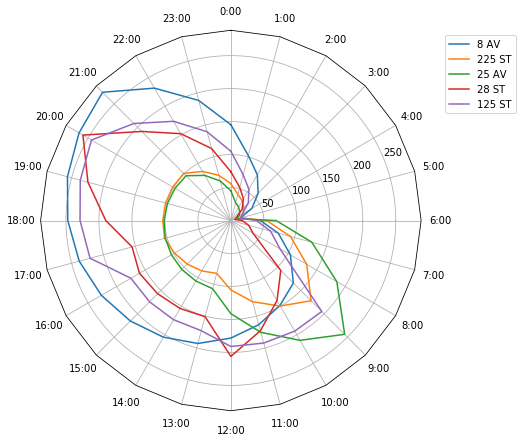

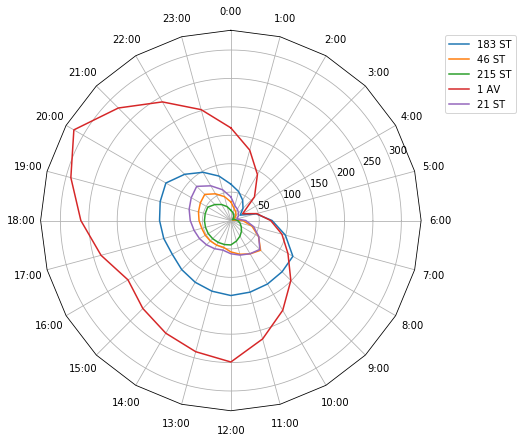

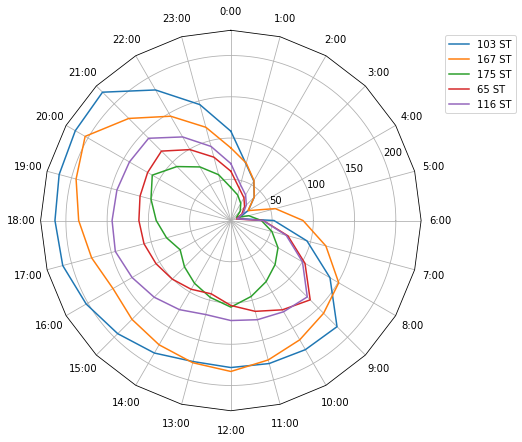

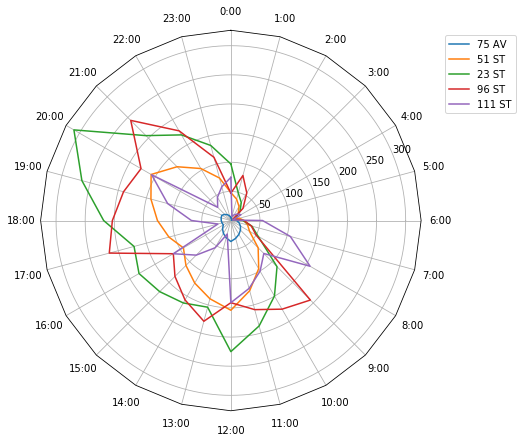

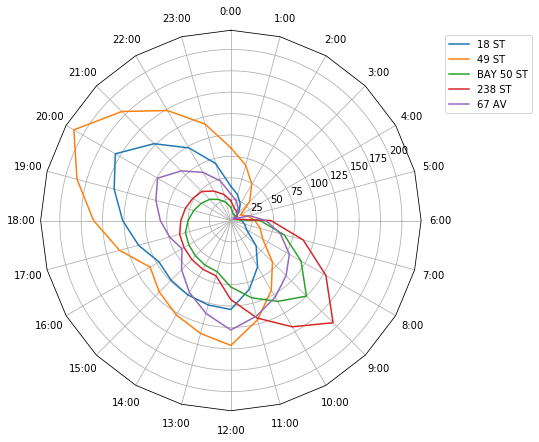

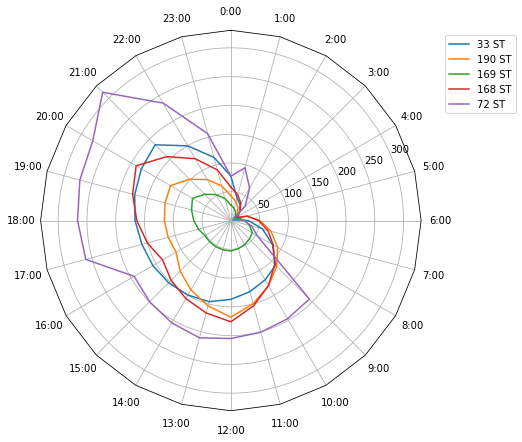

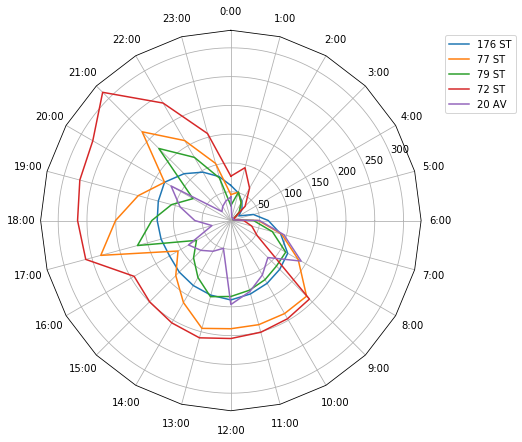

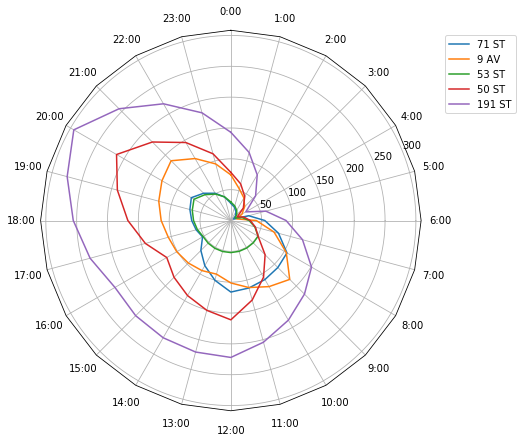

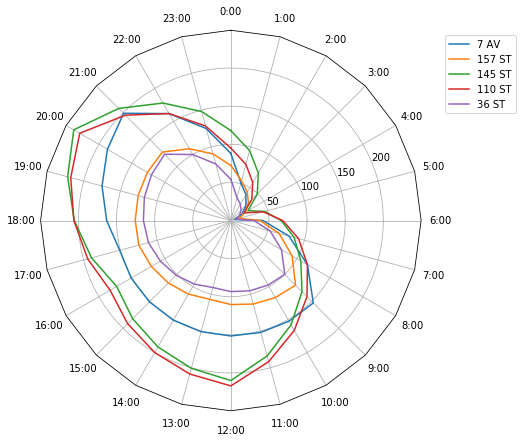

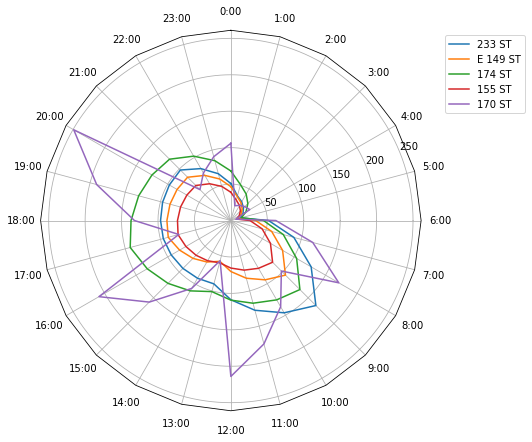

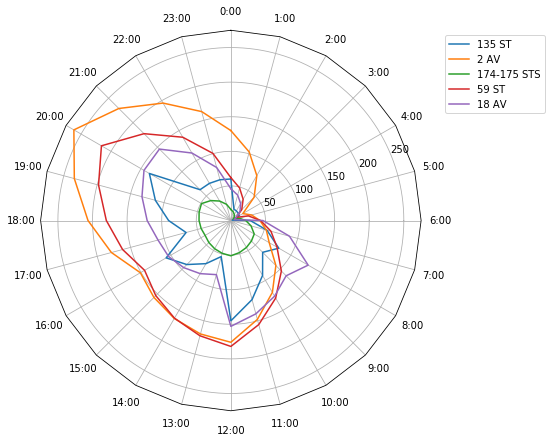

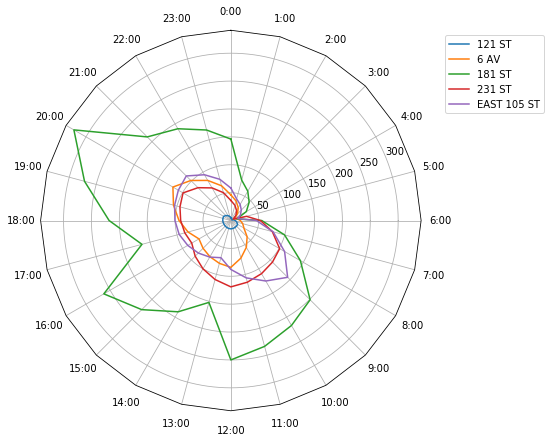

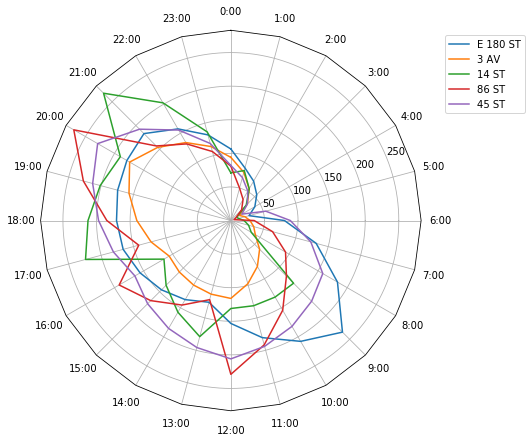

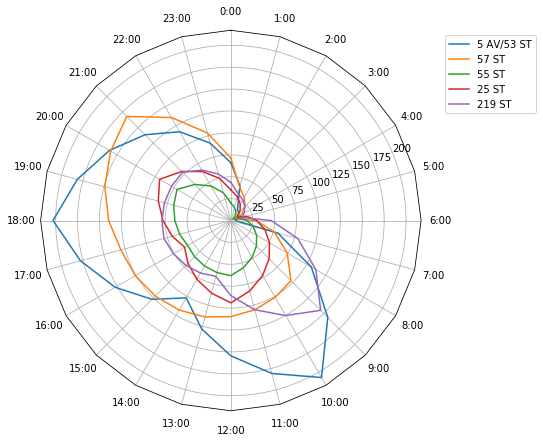

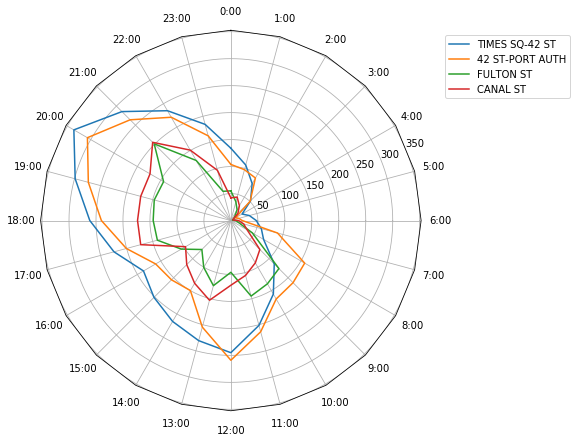

In [25]:
grid = range(23, 0, -1)
grid = [0] + grid

n = 5
#stations = ['215 ST','8 AV']
for i in range(len(stations)//n):
    stations_part = stations[i*n:min((i+1)*n,len(stations))]
    y = {}
    for station in stations_part:
        y[station] = []
        for x in grid:
            y[station].append(interpolation(x, station, df_time_station_count))
            x = x + 2 % 24
    radar_graph(labels = [str(x) + ":00" for x in grid], values=y)

In [45]:
station_traffic_df = pd.DataFrame(stations, columns=['Stations'])
columns = []
column_names = []
for h in range(0, 240):
    column_names.append(str(h/10))
    columns.append(station_traffic_df['Stations']
                   .apply(lambda s: interpolation((h/10 + 2) % 24, s, df_time_station_count)))
station_traffic_df[column_names] = columns
station_traffic_df.set_index('Stations')

KeyError: "['0.0' '0.1' '0.2' '0.3' '0.4' '0.5' '0.6' '0.7' '0.8' '0.9' '1.0' '1.1'\n '1.2' '1.3' '1.4' '1.5' '1.6' '1.7' '1.8' '1.9' '2.0' '2.1' '2.2' '2.3'\n '2.4' '2.5' '2.6' '2.7' '2.8' '2.9' '3.0' '3.1' '3.2' '3.3' '3.4' '3.5'\n '3.6' '3.7' '3.8' '3.9' '4.0' '4.1' '4.2' '4.3' '4.4' '4.5' '4.6' '4.7'\n '4.8' '4.9' '5.0' '5.1' '5.2' '5.3' '5.4' '5.5' '5.6' '5.7' '5.8' '5.9'\n '6.0' '6.1' '6.2' '6.3' '6.4' '6.5' '6.6' '6.7' '6.8' '6.9' '7.0' '7.1'\n '7.2' '7.3' '7.4' '7.5' '7.6' '7.7' '7.8' '7.9' '8.0' '8.1' '8.2' '8.3'\n '8.4' '8.5' '8.6' '8.7' '8.8' '8.9' '9.0' '9.1' '9.2' '9.3' '9.4' '9.5'\n '9.6' '9.7' '9.8' '9.9' '10.0' '10.1' '10.2' '10.3' '10.4' '10.5' '10.6'\n '10.7' '10.8' '10.9' '11.0' '11.1' '11.2' '11.3' '11.4' '11.5' '11.6'\n '11.7' '11.8' '11.9' '12.0' '12.1' '12.2' '12.3' '12.4' '12.5' '12.6'\n '12.7' '12.8' '12.9' '13.0' '13.1' '13.2' '13.3' '13.4' '13.5' '13.6'\n '13.7' '13.8' '13.9' '14.0' '14.1' '14.2' '14.3' '14.4' '14.5' '14.6'\n '14.7' '14.8' '14.9' '15.0' '15.1' '15.2' '15.3' '15.4' '15.5' '15.6'\n '15.7' '15.8' '15.9' '16.0' '16.1' '16.2' '16.3' '16.4' '16.5' '16.6'\n '16.7' '16.8' '16.9' '17.0' '17.1' '17.2' '17.3' '17.4' '17.5' '17.6'\n '17.7' '17.8' '17.9' '18.0' '18.1' '18.2' '18.3' '18.4' '18.5' '18.6'\n '18.7' '18.8' '18.9' '19.0' '19.1' '19.2' '19.3' '19.4' '19.5' '19.6'\n '19.7' '19.8' '19.9' '20.0' '20.1' '20.2' '20.3' '20.4' '20.5' '20.6'\n '20.7' '20.8' '20.9' '21.0' '21.1' '21.2' '21.3' '21.4' '21.5' '21.6'\n '21.7' '21.8' '21.9' '22.0' '22.1' '22.2' '22.3' '22.4' '22.5' '22.6'\n '22.7' '22.8' '22.9' '23.0' '23.1' '23.2' '23.3' '23.4' '23.5' '23.6'\n '23.7' '23.8' '23.9'] not in index"

In [42]:
station_traffic_df.to_csv('Station_Hourly.csv')

In [29]:
pd.DataFrame(df_time_station_count.STATION.unique()).to_csv('stations.csv')